# Naive Bayes Classification

## Theoretical Foundation

Naive Bayes is a family of probabilistic classifiers based on **Bayes' theorem** with a strong (naive) independence assumption between features. Despite its simplicity, Naive Bayes often performs surprisingly well in practice, particularly for text classification and spam filtering.

### Bayes' Theorem

The foundation of Naive Bayes is Bayes' theorem, which describes the probability of an event based on prior knowledge:

$$P(C_k | \mathbf{x}) = \frac{P(\mathbf{x} | C_k) P(C_k)}{P(\mathbf{x})}$$

Where:
- $P(C_k | \mathbf{x})$ is the **posterior probability** of class $C_k$ given features $\mathbf{x}$
- $P(\mathbf{x} | C_k)$ is the **likelihood** of features $\mathbf{x}$ given class $C_k$
- $P(C_k)$ is the **prior probability** of class $C_k$
- $P(\mathbf{x})$ is the **evidence** (normalizing constant)

### The Naive Independence Assumption

The "naive" assumption states that all features are conditionally independent given the class:

$$P(\mathbf{x} | C_k) = P(x_1, x_2, \ldots, x_n | C_k) = \prod_{i=1}^{n} P(x_i | C_k)$$

This simplification allows for efficient computation even with high-dimensional feature spaces.

### Classification Rule

The Naive Bayes classifier assigns the class with maximum posterior probability:

$$\hat{y} = \underset{k \in \{1, \ldots, K\}}{\arg\max} \ P(C_k) \prod_{i=1}^{n} P(x_i | C_k)$$

Since $P(\mathbf{x})$ is constant for all classes, it can be ignored in the maximization.

### Gaussian Naive Bayes

For continuous features, we assume each feature follows a Gaussian distribution:

$$P(x_i | C_k) = \frac{1}{\sqrt{2\pi\sigma_{k,i}^2}} \exp\left(-\frac{(x_i - \mu_{k,i})^2}{2\sigma_{k,i}^2}\right)$$

Where $\mu_{k,i}$ and $\sigma_{k,i}^2$ are the mean and variance of feature $i$ for class $k$.

## Implementation from Scratch

We will implement Gaussian Naive Bayes from scratch and apply it to a synthetic classification problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes classifier implementation.
    
    Assumes features are continuous and follow Gaussian distributions.
    """
    
    def __init__(self):
        self.classes = None
        self.priors = None
        self.means = None
        self.variances = None
    
    def fit(self, X, y):
        """
        Fit the Naive Bayes model.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target labels
        """
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        # Initialize parameters
        self.priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, n_features))
        self.variances = np.zeros((n_classes, n_features))
        
        # Calculate statistics for each class
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.priors[idx] = len(X_c) / n_samples
            self.means[idx, :] = X_c.mean(axis=0)
            self.variances[idx, :] = X_c.var(axis=0) + 1e-9  # Add small value for numerical stability
        
        return self
    
    def _gaussian_likelihood(self, x, mean, var):
        """
        Calculate Gaussian probability density.
        
        P(x|C_k) = (1/sqrt(2*pi*var)) * exp(-(x-mean)^2 / (2*var))
        """
        coefficient = 1.0 / np.sqrt(2.0 * np.pi * var)
        exponent = np.exp(-(x - mean) ** 2 / (2.0 * var))
        return coefficient * exponent
    
    def _calculate_posterior(self, x):
        """
        Calculate posterior probability for each class.
        
        Uses log probabilities to avoid numerical underflow.
        """
        posteriors = []
        
        for idx, c in enumerate(self.classes):
            # Log prior
            prior = np.log(self.priors[idx])
            
            # Sum of log likelihoods (product becomes sum in log space)
            likelihood = np.sum(np.log(self._gaussian_likelihood(
                x, self.means[idx, :], self.variances[idx, :]
            )))
            
            posterior = prior + likelihood
            posteriors.append(posterior)
        
        return posteriors
    
    def predict(self, X):
        """
        Predict class labels for samples in X.
        """
        predictions = []
        for x in X:
            posteriors = self._calculate_posterior(x)
            predictions.append(self.classes[np.argmax(posteriors)])
        return np.array(predictions)
    
    def predict_proba(self, X):
        """
        Predict class probabilities for samples in X.
        """
        probas = []
        for x in X:
            posteriors = np.array(self._calculate_posterior(x))
            # Convert log probabilities to probabilities using softmax
            posteriors = posteriors - np.max(posteriors)  # Numerical stability
            exp_posteriors = np.exp(posteriors)
            probas.append(exp_posteriors / np.sum(exp_posteriors))
        return np.array(probas)

## Generate Synthetic Dataset

We create a binary classification problem with two Gaussian-distributed classes.

In [3]:
def generate_synthetic_data(n_samples_per_class=200):
    """
    Generate synthetic 2D data from two Gaussian distributions.
    """
    # Class 0: centered at (2, 2)
    mean_0 = [2, 2]
    cov_0 = [[1.0, 0.3], [0.3, 1.0]]
    X_0 = np.random.multivariate_normal(mean_0, cov_0, n_samples_per_class)
    y_0 = np.zeros(n_samples_per_class)
    
    # Class 1: centered at (5, 5)
    mean_1 = [5, 5]
    cov_1 = [[1.5, -0.4], [-0.4, 1.5]]
    X_1 = np.random.multivariate_normal(mean_1, cov_1, n_samples_per_class)
    y_1 = np.ones(n_samples_per_class)
    
    # Combine data
    X = np.vstack([X_0, X_1])
    y = np.hstack([y_0, y_1])
    
    # Shuffle
    shuffle_idx = np.random.permutation(len(y))
    X, y = X[shuffle_idx], y[shuffle_idx]
    
    return X, y

# Generate data
X, y = generate_synthetic_data(200)

# Split into train and test sets
split_idx = int(0.8 * len(y))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 320
Test set size: 80


## Train the Model

In [4]:
# Initialize and train the model
gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

# Display learned parameters
print("Learned Parameters:")
print("="*50)
for idx, c in enumerate(gnb.classes):
    print(f"\nClass {int(c)}:")
    print(f"  Prior P(C_{int(c)}) = {gnb.priors[idx]:.4f}")
    print(f"  Mean μ = {gnb.means[idx]}")
    print(f"  Variance σ² = {gnb.variances[idx]}")

Learned Parameters:

Class 0:
  Prior P(C_0) = 0.4906
  Mean μ = [2.00511016 2.05504956]
  Variance σ² = [0.96360734 0.95026   ]

Class 1:
  Prior P(C_1) = 0.5094
  Mean μ = [5.0536528  4.93516763]
  Variance σ² = [1.60319424 1.42001041]


## Evaluate the Model

In [5]:
# Make predictions
y_pred = gnb.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion matrix
def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for i, c_true in enumerate(classes):
        for j, c_pred in enumerate(classes):
            cm[i, j] = np.sum((y_true == c_true) & (y_pred == c_pred))
    return cm

cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

Test Accuracy: 0.9750

Confusion Matrix:
[[42  1]
 [ 1 36]]


## Visualization

We visualize the decision boundary and class distributions.

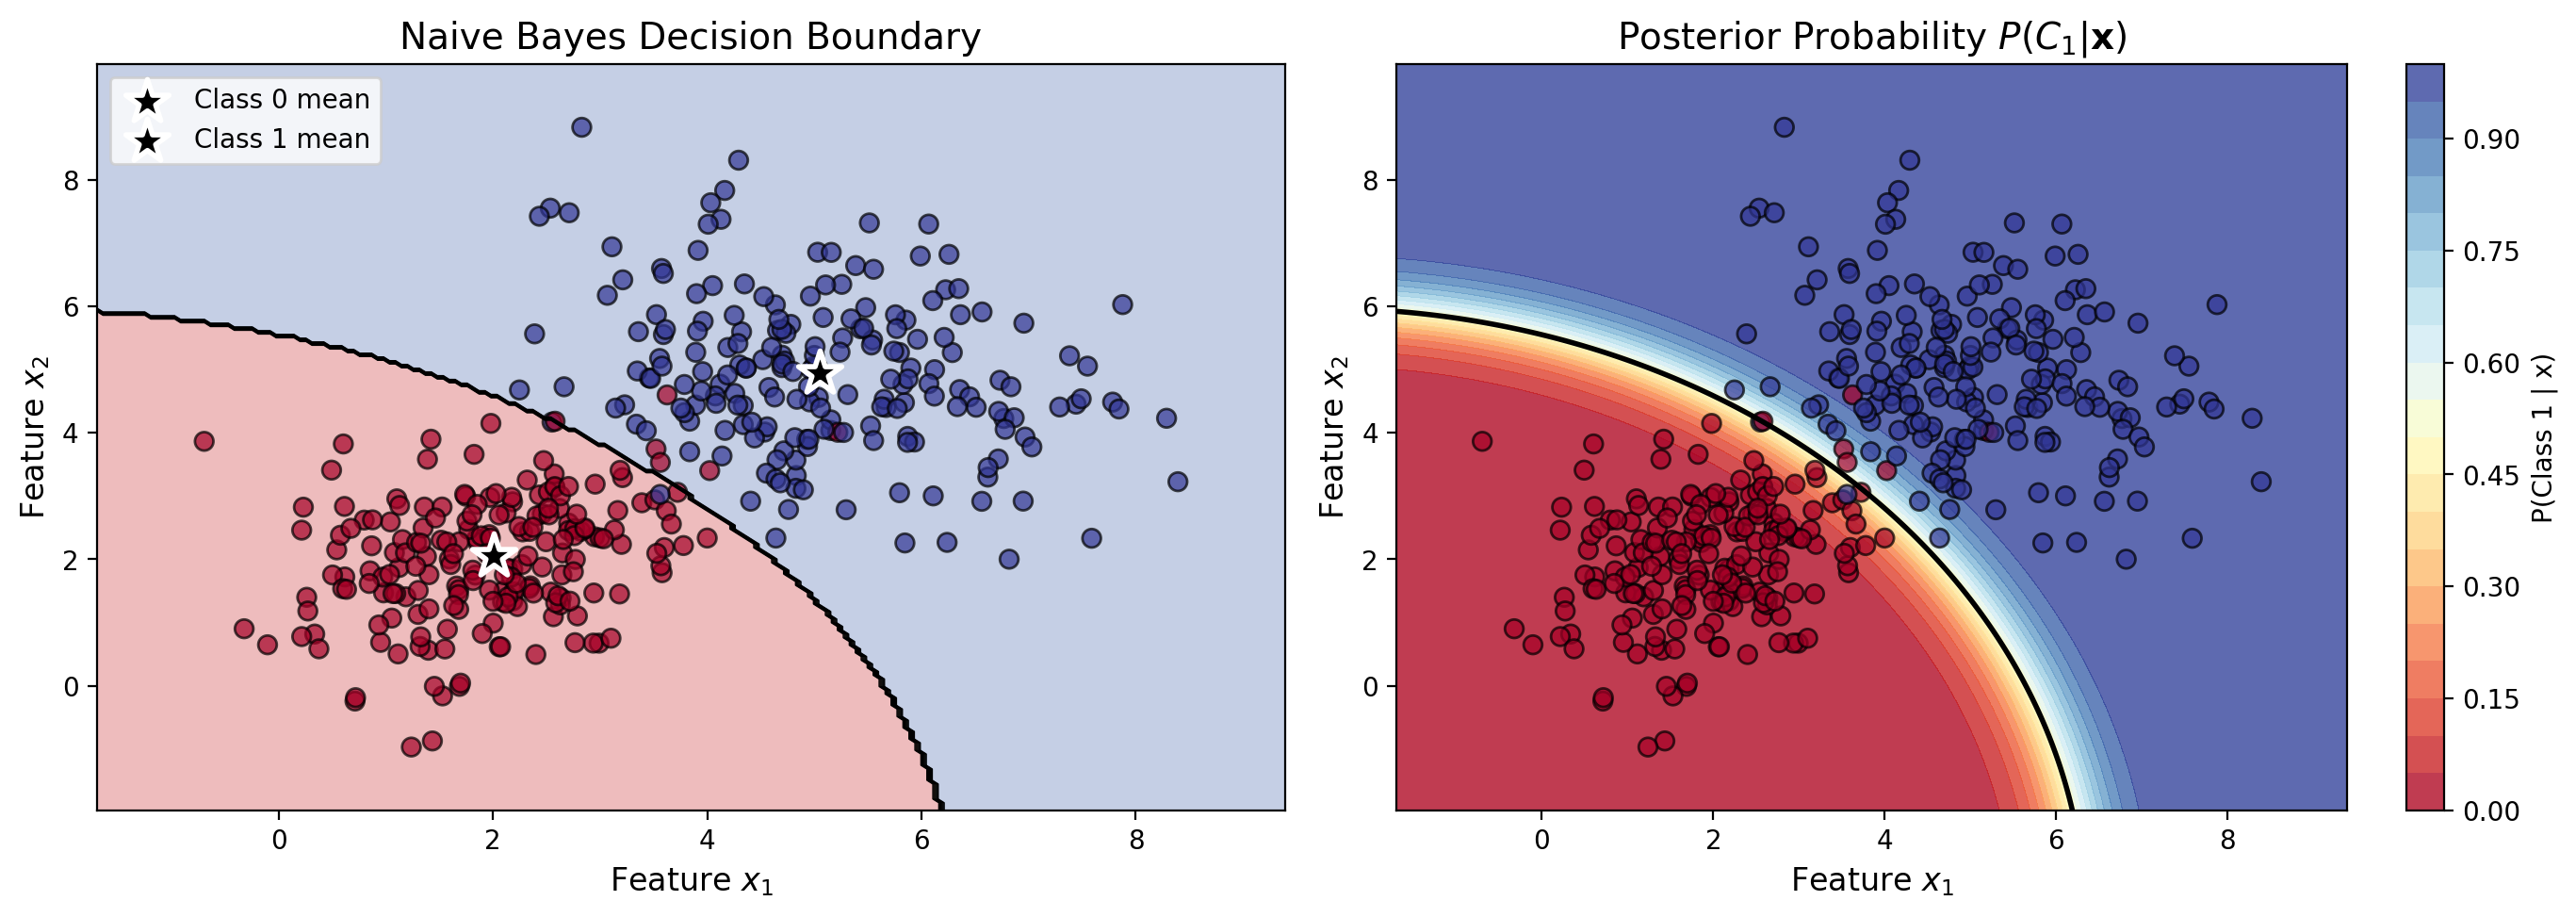


Plot saved to plot.png


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Decision Boundary
ax1 = axes[0]

# Create mesh grid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on mesh
Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
ax1.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
ax1.contour(xx, yy, Z, colors='k', linewidths=0.5)

# Plot data points
scatter = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', 
                      edgecolors='k', alpha=0.7, s=50)

# Mark class means
for idx, c in enumerate(gnb.classes):
    ax1.scatter(gnb.means[idx, 0], gnb.means[idx, 1], 
               marker='*', s=300, c='black', edgecolors='white', linewidths=2,
               label=f'Class {int(c)} mean')

ax1.set_xlabel('Feature $x_1$', fontsize=12)
ax1.set_ylabel('Feature $x_2$', fontsize=12)
ax1.set_title('Naive Bayes Decision Boundary', fontsize=14)
ax1.legend(loc='upper left')

# Plot 2: Probability Contours
ax2 = axes[1]

# Get probability predictions
Z_proba = gnb.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z_proba = Z_proba.reshape(xx.shape)

# Plot probability contours
contour = ax2.contourf(xx, yy, Z_proba, levels=20, cmap='RdYlBu', alpha=0.8)
plt.colorbar(contour, ax=ax2, label='P(Class 1 | x)')

# Plot data points
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', 
           edgecolors='k', alpha=0.7, s=50)

# Add decision boundary (P=0.5)
ax2.contour(xx, yy, Z_proba, levels=[0.5], colors='k', linewidths=2)

ax2.set_xlabel('Feature $x_1$', fontsize=12)
ax2.set_ylabel('Feature $x_2$', fontsize=12)
ax2.set_title('Posterior Probability $P(C_1 | \\mathbf{x})$', fontsize=14)

plt.tight_layout()
plt.savefig('naive_bayes_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to plot.png")

## Analysis of the Naive Independence Assumption

The key insight of Naive Bayes is that it treats each feature independently. Let's examine how this affects the likelihood calculation:

In [7]:
# Demonstrate the naive independence assumption
print("Demonstrating the Naive Independence Assumption")
print("="*50)

# Take a sample point
sample_point = X_test[0]
print(f"\nSample point: x = {sample_point}")

print("\nLikelihood calculation breakdown:")
for idx, c in enumerate(gnb.classes):
    print(f"\nClass {int(c)}:")
    
    # Calculate individual feature likelihoods
    for i in range(len(sample_point)):
        likelihood_i = norm.pdf(sample_point[i], 
                               gnb.means[idx, i], 
                               np.sqrt(gnb.variances[idx, i]))
        print(f"  P(x_{i+1}={sample_point[i]:.2f} | C_{int(c)}) = {likelihood_i:.6f}")
    
    # Total likelihood (product of individual likelihoods)
    total_likelihood = np.prod([
        norm.pdf(sample_point[i], gnb.means[idx, i], np.sqrt(gnb.variances[idx, i]))
        for i in range(len(sample_point))
    ])
    print(f"  P(x | C_{int(c)}) = {total_likelihood:.6f}")
    print(f"  Prior P(C_{int(c)}) = {gnb.priors[idx]:.4f}")
    print(f"  Unnormalized posterior ∝ {total_likelihood * gnb.priors[idx]:.6f}")

Demonstrating the Naive Independence Assumption

Sample point: x = [0.84549093 1.61622745]

Likelihood calculation breakdown:

Class 0:
  P(x_1=0.85 | C_0) = 0.202270
  P(x_2=1.62 | C_0) = 0.369816
  P(x | C_0) = 0.074802
  Prior P(C_0) = 0.4906
  Unnormalized posterior ∝ 0.036700

Class 1:
  P(x_1=0.85 | C_1) = 0.001258
  P(x_2=1.62 | C_1) = 0.006923
  P(x | C_1) = 0.000009
  Prior P(C_1) = 0.5094
  Unnormalized posterior ∝ 0.000004


## Conclusion

### Key Takeaways

1. **Simplicity**: Naive Bayes is computationally efficient, requiring only $O(n \cdot K)$ parameters where $n$ is the number of features and $K$ is the number of classes.

2. **Robustness**: Despite the naive independence assumption being rarely true in practice, the classifier often performs well because it only needs the correct *ranking* of probabilities, not their exact values.

3. **Interpretability**: The model parameters (means and variances) have clear probabilistic interpretations.

4. **Scalability**: Training is linear in the number of samples, making it suitable for large datasets.

### Limitations

- The independence assumption may lead to suboptimal decision boundaries when features are highly correlated
- Probability estimates are often poorly calibrated
- Cannot capture feature interactions without explicit feature engineering

### Extensions

- **Multinomial Naive Bayes**: For discrete count data (e.g., word frequencies)
- **Bernoulli Naive Bayes**: For binary features
- **Complement Naive Bayes**: For imbalanced datasets